<a href="https://colab.research.google.com/github/lkmnop/garbage_classification_Sandhya_Lokesh/blob/main/TLGRGC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np  # Importing NumPy for numerical operations and array manipulations
import matplotlib.pyplot as plt  # Importing Matplotlib for plotting graphs and visualizations
import seaborn as sns  # Importing Seaborn for statistical data visualization, built on top of Matplotlib
import tensorflow as tf  # Importing TensorFlow for building and training machine learning models
from tensorflow import keras  # Importing Keras, a high-level API for TensorFlow, to simplify model building
from tensorflow.keras import Layer  # Importing Layer class for creating custom layers in Keras
from tensorflow.keras.models import Sequential  # Importing Sequential model for building neural networks layer-by-layer
from tensorflow.keras.layers import Rescaling , GlobalAveragePooling2D
from tensorflow.keras import layers, optimizers, callbacks  # Importing various modules for layers, optimizers, and callbacks in Keras
from sklearn.utils.class_weight import compute_class_weight  # Importing function to compute class weights for imbalanced datasets
from tensorflow.keras.applications import EfficientNetV2B2  # Importing EfficientNetV2S model for transfer learning
from sklearn.metrics import confusion_matrix, classification_report  # Importing functions to evaluate model performance
import gradio as gr  # Importing Gradio for creating interactive web interfaces for machine learning models

In [ ]:
dataset_dir= r"/content/drive/MyDrive/garbage/TrashType_Image_Dataset"
image_size=(124,124)
batch_size = 32
seed = 42

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)
class_names = train_ds.class_names

Found 2537 files belonging to 6 classes.
Using 2030 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)
val_class= val_ds.class_names

Found 2537 files belonging to 6 classes.
Using 507 files for validation.


In [ ]:
# Get the total number of batches in the validation dataset
val_batches = tf.data.experimental.cardinality(val_ds)

# Split the validation dataset into two equal parts:
# First half becomes the test dataset
test_ds = val_ds.take(val_batches // 2)

# Second half remains as the validation dataset
val_dat = val_ds.skip(val_batches // 2)

# Optimize test dataset by caching and prefetching to improve performance
test_ds_eval = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
print(train_ds.class_names)
print(val_class)
print(len(train_ds.class_names))

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
6


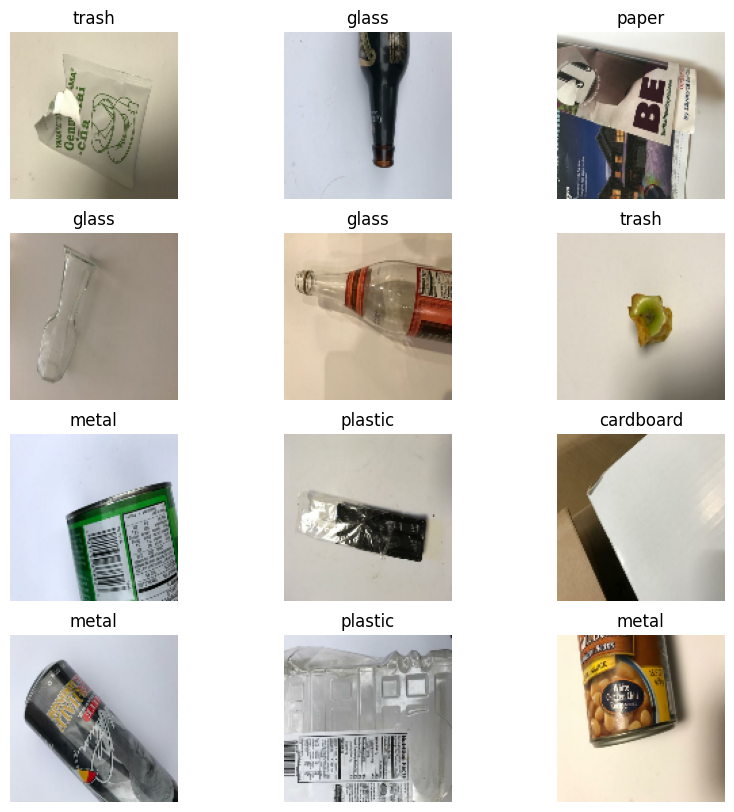

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

In [ ]:
def count_distribution_fast(dataset, class_names):
    # Flatten all labels and count them efficiently
    counts_tensor = dataset \
        .map(lambda x, y: y) \
        .unbatch() \
        .reduce(tf.zeros(len(class_names), dtype=tf.int32),
                lambda acc, y: acc + tf.one_hot(y, depth=len(class_names), dtype=tf.int32))

    counts = counts_tensor.numpy()
    total = counts.sum()

    # Convert to percentage
    return {class_names[i]: round((counts[i] / total) * 100, 2) for i in range(len(class_names))}

In [ ]:
train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
def simple_bar_plot(distribution_dict, title):
    classes = list(distribution_dict.keys())
    values = list(distribution_dict.values())

    plt.figure(figsize=(8, 5))
    bars = plt.bar(classes, values, color='skyblue', edgecolor='black')
    plt.xlabel("Class")
    plt.ylabel("Percentage")
    plt.title(title)

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.1f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

Train: {'cardboard': np.float64(16.45), 'glass': np.float64(19.66), 'metal': np.float64(16.4), 'paper': np.float64(23.2), 'plastic': np.float64(19.11), 'trash': np.float64(5.17)}
Val: {'cardboard': np.float64(13.61), 'glass': np.float64(20.12), 'metal': np.float64(17.16), 'paper': np.float64(24.26), 'plastic': np.float64(18.54), 'trash': np.float64(6.31)}
Test: {'cardboard': np.float64(13.67), 'glass': np.float64(18.75), 'metal': np.float64(16.02), 'paper': np.float64(23.05), 'plastic': np.float64(21.48), 'trash': np.float64(7.03)}
Overall: {'cardboard': np.float64(15.03), 'glass': np.float64(19.89), 'metal': np.float64(16.78), 'paper': np.float64(23.73), 'plastic': np.float64(18.82), 'trash': np.float64(5.74)}


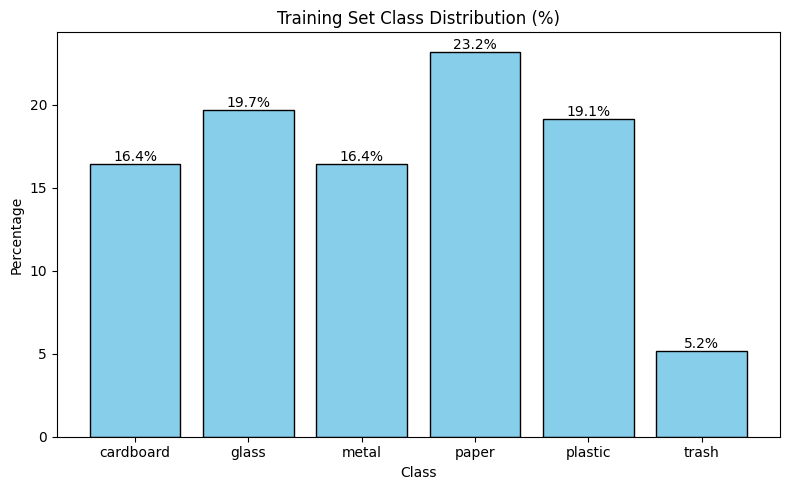

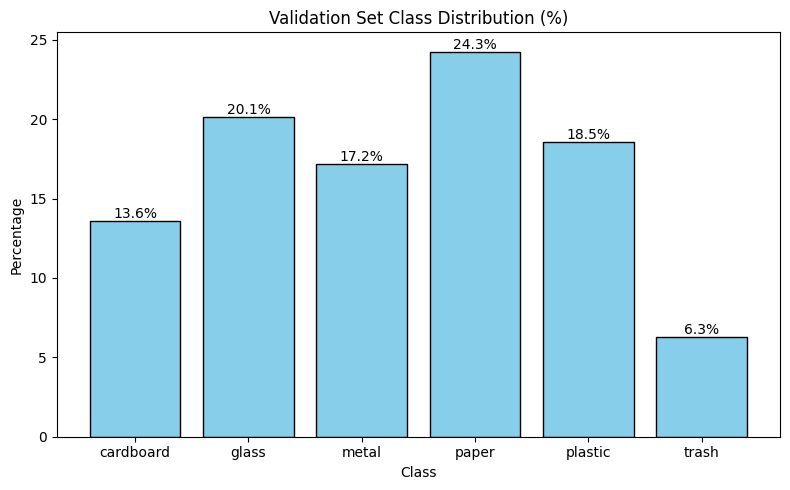

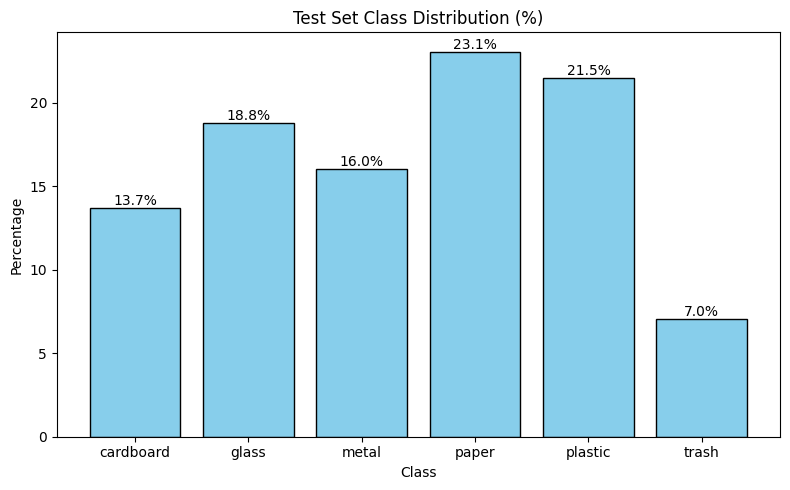

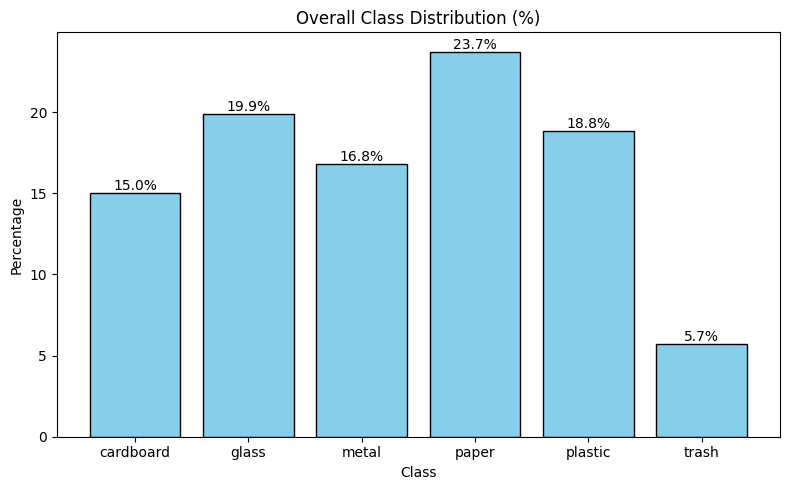

In [ ]:
train_dist = count_distribution_fast(train_ds, class_names)
val_dist = count_distribution_fast(val_ds, class_names)
test_dist = count_distribution_fast(test_ds, class_names)

overall_dist = {
    k: round((train_dist[k] + val_dist[k]) / 2, 2)
    for k in class_names
}

print("Train:", train_dist)
print("Val:", val_dist)
print("Test:", test_dist)
print("Overall:", overall_dist)


# Plot if needed
simple_bar_plot(train_dist, "Training Set Class Distribution (%)")
simple_bar_plot(val_dist, "Validation Set Class Distribution (%)")
simple_bar_plot(test_dist, "Test Set Class Distribution (%)")
simple_bar_plot(overall_dist, "Overall Class Distribution (%)")

In [ ]:

class_counts = {i: 0 for i in range(len(class_names))}
all_labels = []

for images, labels in train_ds:
    for label in labels.numpy():
        class_counts[label] += 1
        all_labels.append(label)

# Compute class weights (index aligned)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=all_labels
)

# Create dictionary mapping class index to weight
class_weights = {i: w for i, w in enumerate(class_weights_array)}

In [ ]:
print("Class Counts:", class_counts)
print("Class Weights:", class_weights)

Class Counts: {0: 334, 1: 399, 2: 333, 3: 471, 4: 388, 5: 105}
Class Weights: {0: np.float64(1.0129740518962076), 1: np.float64(0.847953216374269), 2: np.float64(1.016016016016016), 3: np.float64(0.7183297947629158), 4: np.float64(0.8719931271477663), 5: np.float64(3.2222222222222223)}


In [ ]:
#  Define data augmentation pipeline
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

In [ ]:
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

# Normalization layer (EfficientNet expects specific normalization)
normalization_layer = layers.Lambda(preprocess_input)


In [ ]:
def prepare_dataset(ds, training=False):
    # Shuffle, augment, normalize, and prefetch
    ds = ds.map(lambda x, y: (tf.image.resize(x, image_size), y), num_parallel_calls=tf.data.AUTOTUNE)

    if training:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)

    # Normalize using EfficientNet's preprocess_input
    ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)

    return ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_ds_prep = prepare_dataset(train_ds, training=True)
val_ds_prep = prepare_dataset(val_dat)
test_ds_prep = prepare_dataset(test_ds_eval)


In [ ]:
#  Load the pretrained MobileNetV3Small model (without the top classification layer)
base_model = EfficientNetV2B2(include_top=False, input_shape=(124, 124, 3),include_preprocessing=True, weights='imagenet')


#  Freeze early layers (to retain general pretrained features)
base_model.trainable = True
for layer in base_model.layers[:100]:  # You can adjust this number
    layer.trainable = False

35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
# Load EfficientNetV2B2 without the top classification layer
base_model = EfficientNetV2B2(
    include_top=False,
    input_shape=(image_size[0], image_size[1], 3),
    weights='imagenet'  # Use pre-trained ImageNet weights
)


In [ ]:
# Freeze all layers in the base model
base_model.trainable = False

In [ ]:
inputs = keras.Input(shape=(image_size[0], image_size[1], 3))
x = data_augmentation(inputs)                     # Optional: If not applied during preprocessing
x = preprocess_input(x)                           # Normalize for EfficientNet
x = base_model(x, training=False)                 # Base model (frozen)
x = GlobalAveragePooling2D()(x)                   # Reduce feature map to 1D
x = layers.Dropout(0.3)(x)                         # Regularization
outputs = layers.Dense(len(class_names), activation='softmax')(x)  # Output layer

model = keras.Model(inputs, outputs)

In [ ]:
checkpoint_cb = callbacks.ModelCheckpoint(
    "best_model.h5",
    save_best_only=True,
    monitor="val_accuracy",
    mode="max"
)

earlystop_cb = callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True
)

reduce_lr_cb = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    min_lr=1e-6
)


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds_prep,
    validation_data=val_ds_prep,
    epochs=20,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr_cb],
    class_weight=dict(enumerate(class_weights_array))  # e.g., {0: 1.2, 1: 0.8, ...}
)


Epoch 1/20
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.1501 - loss: 1.9119

64/64 ━━━━━━━━━━━━━━━━━━━━ 37s 165ms/step - accuracy: 0.1509 - loss: 1.9116 - val_accuracy: 0.2390 - val_loss: 1.7475 - learning_rate: 1.0000e-04
Epoch 2/20
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2556 - loss: 1.7530

64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.2564 - loss: 1.7522 - val_accuracy: 0.3865 - val_loss: 1.5643 - learning_rate: 1.0000e-04
Epoch 3/20
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3678 - loss: 1.6108

64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.3684 - loss: 1.6094 - val_accuracy: 0.5259 - val_loss: 1.4147 - learning_rate: 1.0000e-04
Epoch 4/20
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4519 - loss: 1.5119

64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.4524 - loss: 1.5101 - val_accuracy: 0.6016 - val_loss: 1.2985 - learning_rate: 1.0000e-04
Epoch 5/20
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5280 - loss: 1.3652

64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.5286 - loss: 1.3647 - val_accuracy: 0.6295 - val_loss: 1.1988 - learning_rate: 1.0000e-04
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5628 - loss: 1.2954

64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.5631 - loss: 1.2949 - val_accuracy: 0.6414 - val_loss: 1.1217 - learning_rate: 1.0000e-04
Epoch 7/20
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6100 - loss: 1.2159

64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6097 - loss: 1.2152 - val_accuracy: 0.6574 - val_loss: 1.0557 - learning_rate: 1.0000e-04
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6309 - loss: 1.1319

64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.6309 - loss: 1.1321 - val_accuracy: 0.6813 - val_loss: 1.0051 - learning_rate: 1.0000e-04
Epoch 9/20
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6448 - loss: 1.0929

64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.6447 - loss: 1.0929 - val_accuracy: 0.6932 - val_loss: 0.9587 - learning_rate: 1.0000e-04
Epoch 10/20
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6563 - loss: 1.0873

64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6564 - loss: 1.0860 - val_accuracy: 0.7012 - val_loss: 0.9233 - learning_rate: 1.0000e-04
Epoch 11/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6756 - loss: 1.0169

64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.6753 - loss: 1.0171 - val_accuracy: 0.7251 - val_loss: 0.8908 - learning_rate: 1.0000e-04
Epoch 12/20
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6869 - loss: 0.9699

64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.6867 - loss: 0.9700 - val_accuracy: 0.7410 - val_loss: 0.8590 - learning_rate: 1.0000e-04
Epoch 13/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.6899 - loss: 0.9817 - val_accuracy: 0.7410 - val_loss: 0.8336 - learning_rate: 1.0000e-04
Epoch 14/20
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7132 - loss: 0.8965

64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.7128 - loss: 0.8974 - val_accuracy: 0.7649 - val_loss: 0.8126 - learning_rate: 1.0000e-04
Epoch 15/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.6977 - loss: 0.9303 - val_accuracy: 0.7610 - val_loss: 0.7963 - learning_rate: 1.0000e-04
Epoch 16/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.7301 - loss: 0.8619 - val_accuracy: 0.7649 - val_loss: 0.7772 - learning_rate: 1.0000e-04
Epoch 17/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.7140 - loss: 0.8639 - val_accuracy: 0.7570 - val_loss: 0.7645 - learning_rate: 1.0000e-04
Epoch 18/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.7362 - loss: 0.8379 - val_accuracy: 0.7610 - val_loss: 0.7498 - learning_rate: 1.0000e-04
Epoch 19/20
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7400 - loss: 0.8093

64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.7397 - loss: 0.8098 - val_accuracy: 0.7689 - val_loss: 0.7375 - learning_rate: 1.0000e-04
Epoch 20/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.7433 - loss: 0.8159 - val_accuracy: 0.7689 - val_loss: 0.7264 - learning_rate: 1.0000e-04


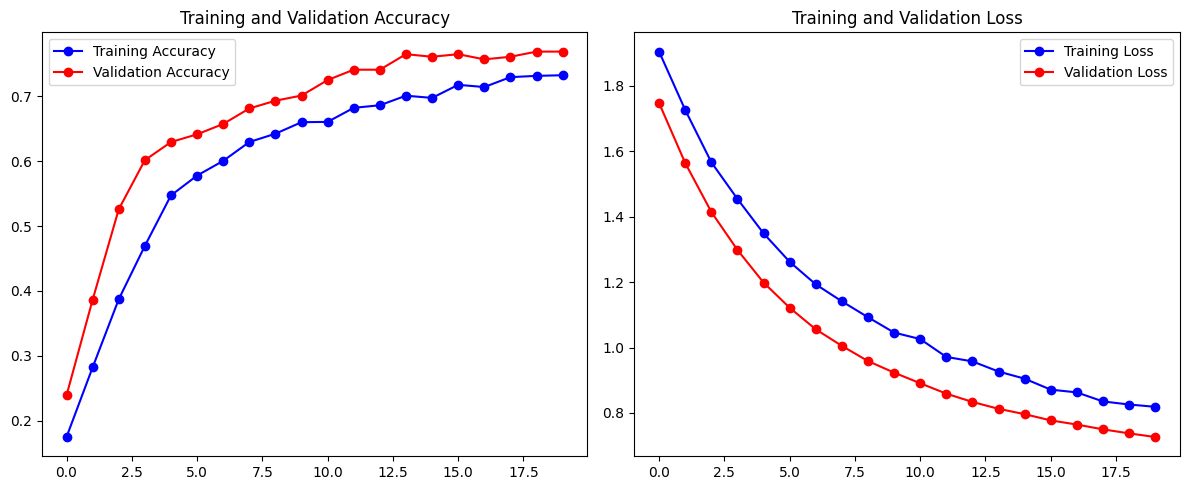

In [ ]:
def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training(history)

In [ ]:
test_loss, test_accuracy = model.evaluate(test_ds_prep)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.8185 - loss: 0.6813
Test Accuracy: 80.86%
Test Loss: 0.6848


In [ ]:
# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in test_ds_prep:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


In [ ]:
# Print classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:

              precision    recall  f1-score   support

   cardboard       0.73      0.95      0.82        39
       glass       0.86      0.80      0.83        54
       metal       0.74      0.82      0.78        38
       paper       1.00      0.75      0.85        67
     plastic       0.83      0.81      0.82        42
       trash       0.55      0.75      0.63        16

    accuracy                           0.81       256
   macro avg       0.78      0.81      0.79       256
weighted avg       0.83      0.81      0.81       256



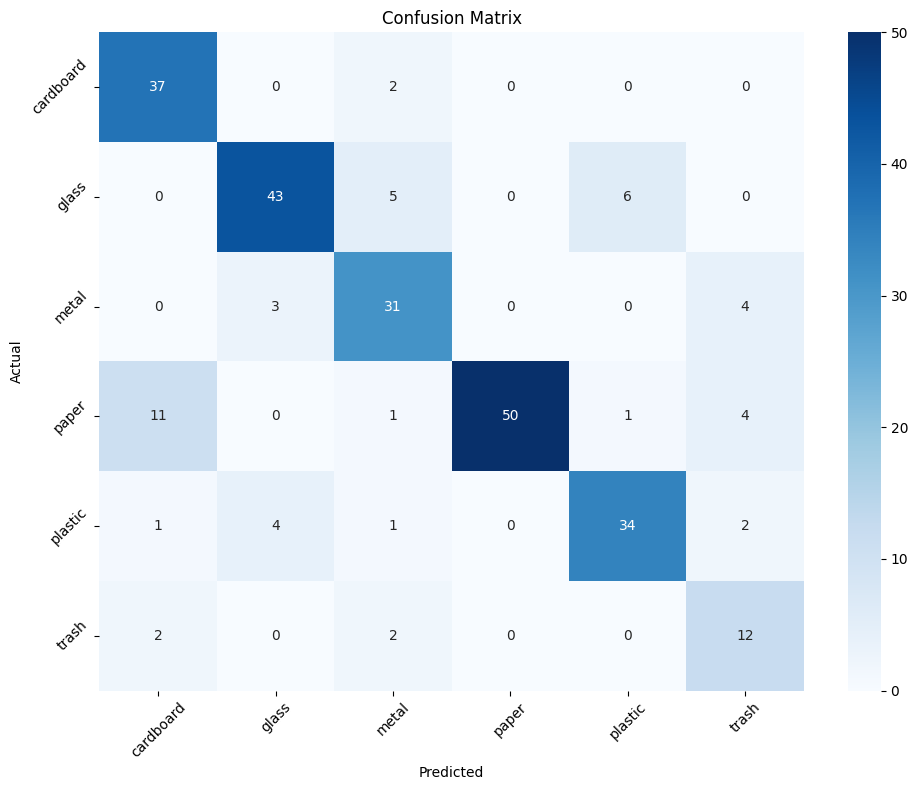

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:


# Define prediction function
def predict_image(image):
    # Resize and preprocess the image
    img = tf.image.resize(image, image_size)
    img = tf.expand_dims(img, axis=0)  # Add batch dimension
    img = preprocess_input(img)        # Normalize using EfficientNet's preprocess_input

    # Predict
    predictions = model.predict(img)
    predicted_class = class_names[np.argmax(predictions)]
    confidence = np.max(predictions)

    return f"Prediction: {predicted_class} ({confidence*100:.2f}% confidence)"


In [ ]:
import gradio as gr

interface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="numpy"),
    outputs="text",
    title="Garbage Classification AI",
    description="Upload an image of garbage, and the model will classify it into categories like plastic, metal, glass, etc.",
    examples=None  # You can add image paths if you want example buttons
)

interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3b02a0ca7265723003.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
base_model.trainable = True  # Unfreeze all layers


In [ ]:
# Unfreeze from a specific layer (e.g., last 30 layers)
fine_tune_at = len(base_model.layers) - 30

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False


In [ ]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
fine_tune_history = model.fit(
    train_ds_prep,
    validation_data=val_ds_prep,
    epochs=10,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr_cb],
    class_weight=dict(enumerate(class_weights_array))
)

Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 29s 124ms/step - accuracy: 0.6734 - loss: 0.9360 - val_accuracy: 0.7410 - val_loss: 0.8139 - learning_rate: 1.0000e-05
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.7075 - loss: 0.9027 - val_accuracy: 0.7450 - val_loss: 0.7988 - learning_rate: 1.0000e-05
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.7147 - loss: 0.8754 - val_accuracy: 0.7530 - val_loss: 0.7878 - learning_rate: 1.0000e-05
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.7105 - loss: 0.8682 - val_accuracy: 0.7570 - val_loss: 0.7656 - learning_rate: 1.0000e-05
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.7066 - loss: 0.8701 - val_accuracy: 0.7570 - val_loss: 0.7686 - learning_rate: 1.0000e-05
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.7102 - loss: 0.8439 - val_accuracy: 0.7610 - val_loss: 0.7592 - learning_rate: 1.0000e-05
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.743

In [ ]:
# Save the final model
model.save("garbage_classifier_finetuned.h5")  # or use ".keras" extension

In [ ]:
model = keras.models.load_model("garbage_classifier_finetuned.h5")


In [ ]:
# Reuse the same Gradio code
interface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="numpy"),
    outputs="text",
    title="Fine-Tuned Garbage Classifier",
    description="Upload an image of garbage and get a high-accuracy prediction using EfficientNetV2B2 (fine-tuned)."
)

interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://08a378d4b122919722.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
